In [1]:
import hubert_model
import librosa
import  torch
import numpy as np
from models import SynthesizerTrn
import utils
import IPython.display as ipd
import matplotlib.pyplot as plt
from preprocess_wave import FeatureInput

hop_size = 640
featureInput = FeatureInput(32000, hop_size)

def resize2d(x, target_len):
    source = np.array(x)
    source[source<0.001] = np.nan
    target = np.interp(np.arange(0, len(source)*target_len, len(source))/ target_len, np.arange(0, len(source)), source)
    res = np.nan_to_num(target)
    return res

DEBUG:matplotlib:matplotlib data path: /Users/xingyijin/.conda/envs/PycharmParent/lib/python3.9/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:CONFIGDIR=/Users/xingyijin/.matplotlib
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is darwin
DEBUG:matplotlib:loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', '_io', 'marshal', 'posix', '_frozen_importlib_external', 'time', 'zipimport', '_codecs', 'codecs', 'encodings.aliases', 'encodings', 'encodings.utf_8', '_signal', 'encodings.latin_1', '_abc', 'abc', 'io', '__main__', '_stat', 'stat', '_collections_abc', 'genericpath', 'posixpath', 'os.path', 'os', '_sitebuiltins', '_locale', '_bootlocale', 'types', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib', 'importlib.machinery', '_heapq', 'heapq', 'itertools', 'keyword', '_operator', 'operator', 'reprlib', '_collections', 'collections', 'collections.abc', '_functools', 'functools', 'contextli

In [2]:
hubert = hubert_model.hubert_soft("hubert-soft-0d54a1f4.pt")

In [3]:
def get_units(in_path, hubert_soft):
    source, sr = librosa.load(in_path, 16000)
    source = torch.FloatTensor(source)
    source = source.unsqueeze(0)
    source = source.unsqueeze(0)
    with torch.inference_mode():
        units = hubert_soft.units(source)
        return units
# get_units("/Users/xingyijin/Downloads/odds(1).wav", hubert).shape


In [4]:
def resize_pitch(source, target_len):
    source = source.astype(float)
    source_len = source.shape[0]
    source[source<0.001] = np.nan
    target = np.zeros([target_len])
    for i in range(target_len):
        target[i] = source[int(source_len*i/target_len)]

    res = np.nan_to_num(target)
    ret = res[:].astype(int)
    return ret

In [11]:
path = "/Users/xingyijin/Downloads/下载.wav"
transform = -4
soft = get_units(path, hubert)
audio, sr = librosa.load(path)
featur_pit = librosa.pyin(audio,
                fmin=librosa.note_to_hz('C0'),
                fmax=librosa.note_to_hz('C7'),
                frame_length=1780,sr=sr)[0]

featur_pit = resize2d(featur_pit, soft.shape[1])
featur_pit = featur_pit * 2**(transform/12)

pitch = featureInput.coarse_f0(featur_pit)
pitch = torch.LongTensor(pitch).unsqueeze(0)


/var/folders/36/6m8zyz714bg9_1lb7qry0kzr0000gn/T/ipykernel_45364/1445350203.py:2: FutureWarning: Pass sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  source, sr = librosa.load(in_path, 16000)


In [6]:
hps = utils.get_hparams_from_file("configs/nyarumul.json")

net = SynthesizerTrn(
    178,
    hps.data.filter_length // 2 + 1,
    hps.train.segment_size // hps.data.hop_length,
    n_speakers=hps.data.n_speakers,
    **hps.model)

In [7]:
_ = utils.load_checkpoint("/Users/xingyijin/Downloads/76_epochs.pth", net, None)

INFO:root:Loaded checkpoint '/Users/xingyijin/Downloads/76_epochs.pth' (iteration None)


In [8]:
# net.n_speakers =
import soundfile as sf

In [12]:
sid = torch.LongTensor([0])
x_lengths = torch.LongTensor([soft.size(1)])
audio = net.infer(soft, x_lengths, pitch, sid, 0.3)[0][0,0].data.float().numpy()
ipd.display(ipd.Audio(audio, rate=hps.data.sampling_rate))
sf.write("/Users/xingyijin/Downloads/syn.wav", audio, hps.data.sampling_rate)

/var/folders/36/6m8zyz714bg9_1lb7qry0kzr0000gn/T/ipykernel_74378/3682349879.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  p = pitch.numpy().astype(np.float)


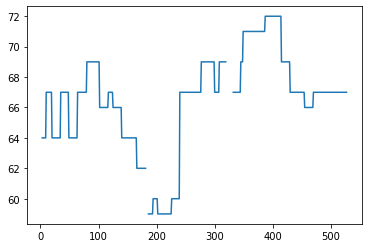

In [16]:
import matplotlib.pyplot as plt
p = pitch.numpy().astype(np.float)
p[p == 0] = np.nan
plt.plot(p[0,:])